# Data Exploration

In this notebook, we'll investigate the classified data for potential errors or suspicious patterns. \
Additionally, we'll compare the news sentiment index against other economic indicators.

## Topic Classification

We will start by examining the topic classification to see if the classifier is working as expected.


In [1]:
import os

import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import requests
import fredapi

In [2]:
df = pd.read_csv('../data/nyt-index.csv', index_col=0, parse_dates=True)
df = df[~df.index.duplicated(keep='first')]

def resample_to_day(df):
    """Resample to daily frequency and fill missing values with expanding mean"""
    sma = df['index_value'].rolling(365, min_periods=1).mean()
    sma = sma.resample('D').ffill()
    
    df = df.resample('D').mean()
    df['index_value'] = df['index_value'].fillna(sma)
    df = df.fillna(0)
    return df

df = resample_to_day(df)
df.head()

,negative,neutral,positive,total,index_value,smoothed_index_value
date,,,,,,
1852-01-01,0.0,1.0,0.0,1.0,0.0,0.0
1852-01-02,0.0,0.0,0.0,0.0,0.0,0.0
1852-01-03,0.0,2.0,0.0,2.0,0.0,0.0
1852-01-04,0.0,0.0,0.0,0.0,0.0,0.0
1852-01-05,1.0,0.0,0.0,1.0,-1.0,0.0


In [3]:
# Get the total number of headlines per day
num_headlines = pd.DataFrame()
for f in os.listdir('../data/classified-nyt-data'):
    if f.endswith('.csv'):
        month = pd.read_csv(f'../data/classified-nyt-data/{f}', index_col=0, parse_dates=True)
        try:
            # count number of headlines per day
            month = month['headline'].groupby(month.index.date).count()
            num_headlines = pd.concat([num_headlines, month], axis=0)
        except Exception as e:
            print(f'Error in file {f}: {e}')
            continue

num_headlines = num_headlines[~num_headlines.index.duplicated(keep='first')]
num_headlines.index = pd.to_datetime(num_headlines.index)
num_headlines.index.name = 'date'
num_headlines = num_headlines.squeeze()
num_headlines = num_headlines.resample('D').mean()
num_headlines = num_headlines.fillna(0)
num_headlines.head()

Error in file 1978-09.csv: 'Index' object has no attribute 'date'
Error in file 1978-10.csv: 'Index' object has no attribute 'date'


date
1852-01-01    59.0
1852-01-02     0.0
1852-01-03    30.0
1852-01-04     0.0
1852-01-05    43.0
Freq: D, Name: 0, dtype: float64

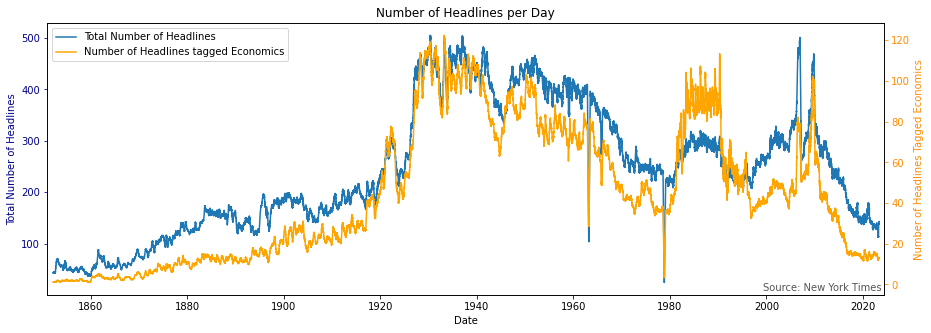

In [4]:
# plot NYT vs. FRBSF news sentiment index
fig, ax = plt.subplots(figsize=(15, 5))
ax2 = ax.twinx()

# Plot total number of headlines
num_headlines_sma = num_headlines.rolling(100).mean()
line1, = ax.plot(num_headlines_sma, label='Total Number of Headlines')
# Plot number of headlines tagged economics
num_economic_headlines_sma = df['total'].rolling(100).mean()
line2, = ax2.plot(num_economic_headlines_sma, label='Number of Headlines tagged Economics', color='orange')

# Set axis colors
ax.tick_params(axis='y', colors='darkblue')
ax.set_ylabel('Total Number of Headlines', color='darkblue')
ax2.tick_params(axis='y', colors='darkorange')
ax2.set_ylabel('Number of Headlines Tagged Economics', color='darkorange')

# Misc. plot settings
xmin = num_headlines_sma.index.min() - pd.Timedelta(days=365)
xmax = num_headlines_sma.index.max() + pd.Timedelta(days=365)
ax.set_xlim([xmin, xmax])
ax2.legend(handles=[line1, line2])
ax.set_xlabel('Date')

# Add sources to plot, Set title
fig.text(0.843, 0.135, 'Source: New York Times', ha='center', fontsize=10, color='#555555')
ax2.set_title('Number of Headlines per Day')
plt.show()

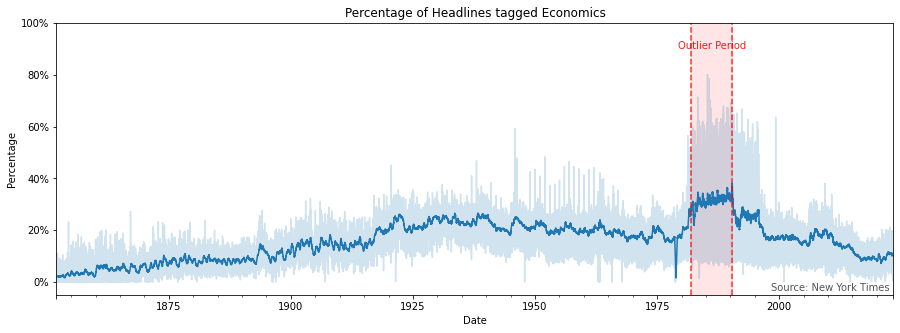

In [5]:
# Plot the percentage headlines tagged as `Economics` per day
econ_headlines_pct = df['total'] / num_headlines * 100
econ_headlines_pct = econ_headlines_pct.replace([np.inf, -np.inf], np.nan).fillna(0)

fig, ax = plt.subplots(figsize=(15, 5))
econ_headlines_pct.plot(ax=ax, alpha=0.2, color='#1f77b4')
econ_headlines_pct.rolling(100).mean().plot(ax=ax)

# Define outlier period start and end
outlier_start = pd.to_datetime('1982-01-01')
outlier_end = pd.to_datetime('1990-06-01')

# Highlight outlier period
ax.axvspan(outlier_start, outlier_end, color='r', alpha=0.1)
ax.vlines(outlier_start, -5, 120, color='red', linestyle='--', alpha=0.8)
ax.vlines(outlier_end, -5, 120, color='red', linestyle='--', alpha=0.8)
ax.text(pd.to_datetime('1986-03-01'), 90, 'Outlier Period', color='red', alpha=0.9, 
        horizontalalignment='center')

# Misc. plot settings
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:.0f}%".format(x)))
plt.ylim(-5, 100)
plt.ylabel('Percentage')
plt.xlabel('Date')

# Add sources to plot, Set title
fig.text(0.896, 0.135, 'Source: New York Times', ha='right', fontsize=10, color='#555555')
plt.title('Percentage of Headlines tagged Economics')

plt.show()

In [6]:
# Get number of articles from the 'Financial Desk'/'Business' section of NYT
files = os.listdir('../data/classified-nyt-data')
start_idx = files.index('1980-01.csv')
files = files[start_idx:]

num_fin_articles = pd.DataFrame()
for f in files:
    if f.endswith('.csv'):
        data = pd.read_csv(f'../data/classified-nyt-data/{f}', index_col=0, parse_dates=True)
        try:
            finance_desk = (
                (data['topic'].str.contains('Financial Desk')) |
                (data['topic'].str.contains('Business'))
            )
            data = finance_desk.groupby(data.index.date).sum()
            num_fin_articles = pd.concat([num_fin_articles, data], axis=0)
        except Exception as e:
            print(f'Error in file {f}: {e}')
            continue

num_fin_articles.index = pd.to_datetime(num_fin_articles.index)
num_fin_articles = num_fin_articles.squeeze()
num_fin_articles.name = 'Num Financial Articles'
num_fin_articles = num_fin_articles.resample('D').mean()
num_fin_articles = num_fin_articles.fillna(0)

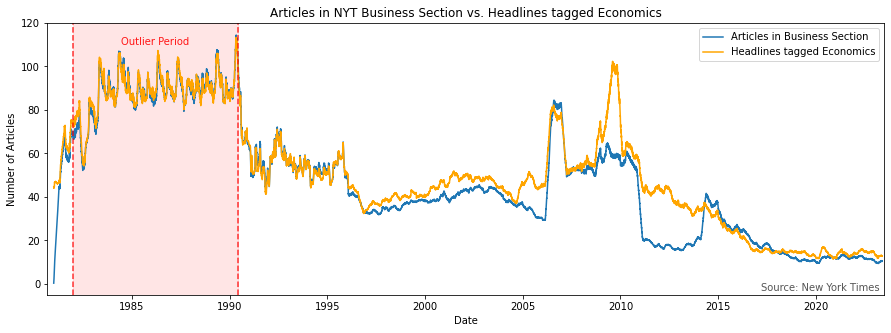

In [7]:
# Create variable for rolling mean
rolling_num_fin_articles = num_fin_articles.rolling(100).mean().loc['1981-01-01':]

# Define plot parameters
figsize = (15, 5)
title = 'Articles in NYT Business Section vs. Headlines tagged Economics'
xlabel = 'Date'
ylabel = 'Number of Articles'
ylim = (-5, 120)
legend_labels = ['Articles in Business Section', 'Headlines tagged Economics']

# Plot lines
fig, ax = plt.subplots(figsize=figsize)
ax.plot(rolling_num_fin_articles, label=legend_labels[0])
ax.plot(num_economic_headlines_sma.loc['1981-01-01':], label=legend_labels[1], color='orange')

# Highlight outlier period
ax.axvspan(outlier_start, outlier_end, color='red', alpha=0.1)
ax.vlines([outlier_start, outlier_end], ylim[0], ylim[1], color='red', linestyle='--', alpha=0.8)
ax.text(outlier_start + (outlier_end - outlier_start) / 2, ylim[1] - 10, 'Outlier Period', color='red', 
        alpha=0.9, horizontalalignment='center')

# Misc. plot settings
plt.legend(legend_labels)
ax.set_ylim(ylim)
ax.set_xlim(pd.to_datetime('1980-09-01'), pd.to_datetime('2023-07-01'))
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)

# Add data source text, set title
fig.text(0.896, 0.135, 'Source: New York Times', ha='right', fontsize=10, color='#555555')
ax.set_title(title)

plt.show()

### Findings
- The percentage of `Economic` news articles in the 1980s looks suspiciously high.
    - Upon further examination, it appears that NYT just published a lot more articles about finance in the 
    1980s than in other decades.
- Also, the percentage of `Economic` news articles relative to all articles rises steadily until ~1920.
    - This is could be due to the fact that the topic classifier is trained on newer data, and the model is not able to accurately classify older articles.

## NYT News Sentiment Index

Here we will examine the Sentiment classifier by constructing the *NYT News Sentiment Index* and comparing it to other economic indicators.

We'll compare the index against:
- S&P 500 bear market dates
- [NBER recession dates](https://fred.stlouisfed.org/series/USRECD)
- [FRBSF Daily News Sentiment Index](https://www.frbsf.org/economic-research/indicators-data/daily-news-sentiment-index/files/news_sentiment_data.xlsx)

In [8]:
# Creating the smoothed and detrended index by taking the difference 
# between the 100-day EMA and the 10-year SMA
hundred_days_ema = df['index_value'].ewm(span=100).mean()
seven_years_sma = df['index_value'].rolling(365*7).mean()
index = hundred_days_ema - seven_years_sma + 0.5  # Detrended index
index.dropna(inplace=True)

In [9]:
# Finding S&P 500 bear market dates

def mark_bear_markets(df, thresh=0.2):
    turning_points = _get_turning_points(df, thresh=thresh)
    turning_points = turning_points.replace(0, np.nan)
    turning_points = turning_points.ffill()
    bear_markets = (turning_points == 1)
    bear_markets.name = f'SPX Bear Markets (-{thresh:.2%})'
    return bear_markets

    
def _get_turning_points(df, thresh=0.2):
    """Get the turning points for a given series where the pct change is
    greater than the threshold."""
    _highs = find_peaks(np.log10(df).values, prominence=(thresh / 2))[0]
    _lows = find_peaks(-np.log10(df).values, prominence=(thresh / 2))[0]

    turning_points = pd.Series(0, index=df.index)
    turning_points.iloc[_highs] = 1
    turning_points[_lows] = -1
    return turning_points

QUANDL_API_KEY = os.environ.get('QUANDL_API_KEY')
url = f'https://www.quandl.com/api/v3/datasets/MULTPL/SP500_REAL_PRICE_MONTH.json?api_key={QUANDL_API_KEY}'
json_data = requests.get(url).json()['dataset']
spx = pd.DataFrame(json_data['data'], columns=json_data['column_names'])

spx.index = pd.DatetimeIndex(spx['Date'])
spx.index.name = 'date'
spx = spx['Value']
spx = spx.resample('D').ffill()

# Bear markets are defined as a 20% decline in the S&P 500 from the previous peak
bear_markets = mark_bear_markets(spx, thresh=0.2)
bear_markets.head()

date
1871-01-01    False
1871-01-02    False
1871-01-03    False
1871-01-04    False
1871-01-05    False
Freq: D, Name: SPX Bear Markets (-20.00%), dtype: bool

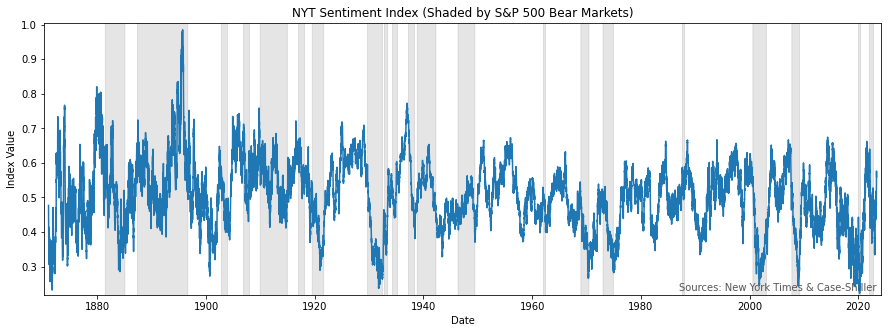

In [10]:
# Plot the index with S&P 500 bear markets shaded
def plot_index_with_shading(df, shading_df, start_date='1900-01-01', title='', source=''):
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(df.loc[start_date:])
    ax.fill_between(shading_df.index, -10, 10, where=shading_df, color='grey', alpha=0.2)

    # Set y-axis limits
    ymax = df.loc[start_date:].max()
    ymin = df.loc[start_date:].min()
    plt.ylim(ymin * 0.98, ymax * 1.02)
    # Set x-axis limits
    num_days = (df.index.max() - df.index.min()).days
    timedelta = pd.Timedelta(days=num_days * 0.005)
    xmin = df.loc[start_date:].index.min() - timedelta
    xmax = df.loc[start_date:].index.max() + timedelta
    plt.xlim(xmin, xmax)

    # Misc. plot settings
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    
    # Add data source text, set title
    fig.text(0.896, 0.135, source, ha='right', fontsize=10, color='#555555')
    ax.set_title(title)
    
    plt.show()

plot_index_with_shading(index, bear_markets, 
                        start_date=bear_markets.index.min(), 
                        title='NYT Sentiment Index (Shaded by S&P 500 Bear Markets)',
                        source='Sources: New York Times & Case-Shiller')

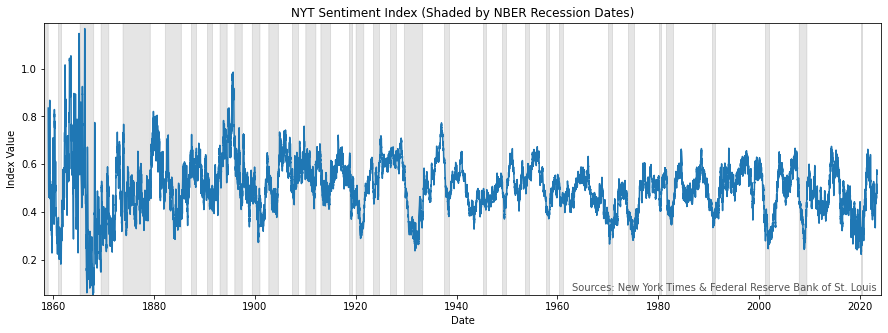

In [11]:
# Plot the index with NBER US recessions dates shaded
FRED_API_KEY = os.environ.get('FRED_API_KEY')
fred = fredapi.Fred(FRED_API_KEY)

recessions = fred.get_series('USRECD').resample('D').ffill()
plot_index_with_shading(index, recessions, 
                        start_date=recessions.index.min(), 
                        title='NYT Sentiment Index (Shaded by NBER Recession Dates)',
                        source='Sources: New York Times & Federal Reserve Bank of St. Louis')

In [12]:
# Compare with the San Francisco FEDs Daily News Sentiment Index
url = 'https://www.frbsf.org/economic-research/indicators-data/'\
      'daily-news-sentiment-index/files/news_sentiment_data.xlsx'
req = requests.get(url)
frbsf_news_sentiment = pd.read_excel(req.content, engine='openpyxl', 
                                     sheet_name='Data', index_col='date').squeeze()

frbsf_news_sentiment.index = pd.to_datetime(frbsf_news_sentiment.index)
frbsf_news_sentiment.name = 'FRBSF Sentiment Index'
frbsf_news_sentiment.head()

date
1980-01-01   -0.038402
1980-01-02   -0.107580
1980-01-03   -0.090856
1980-01-05   -0.068987
1980-01-06   -0.091258
Name: FRBSF Sentiment Index, dtype: float64

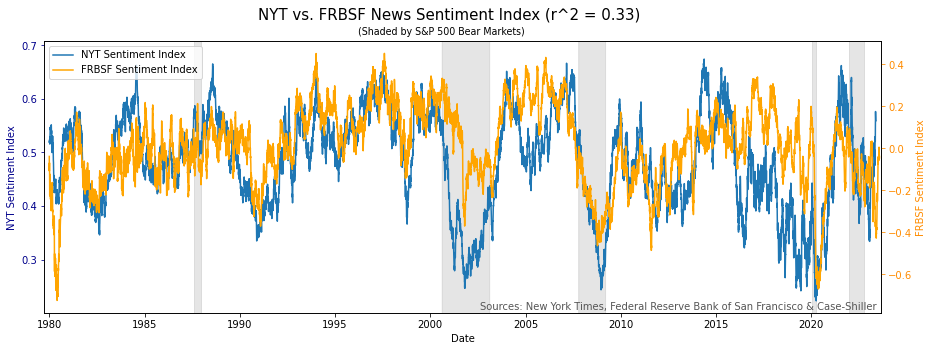

In [13]:
# plot NYT vs. FRBSF news sentiment index
fig, ax = plt.subplots(figsize=(15, 5))
ax2 = ax.twinx()

# Plot lines, add shaded regions
line1, = ax.plot(index.loc['1980-01-01':], label='NYT Sentiment Index')
line2, = ax2.plot(frbsf_news_sentiment, label='FRBSF Sentiment Index', color='orange')
ax.fill_between(bear_markets.index, 0, 1, where=bear_markets, color='grey', alpha=0.2)

# Set y-axis limits
ymin = index.loc['1980-01-01':].min() * 0.90
ymax = index.loc['1980-01-01':].max() * 1.05
ax.set_ylim([ymin, ymax])
# Set x-axis limits
xmin = index.loc['1980-01-01':].index.min() - pd.Timedelta(days=100)
xmax = index.loc['1980-01-01':].index.max() + pd.Timedelta(days=100)
ax.set_xlim([xmin, xmax])

# Set axis colors
ax.tick_params(axis='y', colors='darkblue')
ax.set_ylabel('NYT Sentiment Index', color='darkblue')
ax.set_xlabel('Date')
ax2.tick_params(axis='y', colors='darkorange')
ax2.set_ylabel('FRBSF Sentiment Index', color='darkorange')

# Misc. plot settings
ax2.legend(handles=[line1, line2])

# Add data source text, set title
fig.text(0.896, 0.135, 
         "Sources: New York Times, Federal Reserve Bank of San Francisco & Case-Shiller", 
         ha='right', fontsize=10, color='#555555')
corr = index.loc['1980-01-01':].corr(frbsf_news_sentiment) ** 2
plt.suptitle(f'NYT vs. FRBSF News Sentiment Index (r^2 = {corr:.2f})', size=15, y=0.975)
ax2.set_title('(Shaded by S&P 500 Bear Markets)', size=9.5, x=0.475)

plt.show()

### Findings

- The *NYT Sentiment Index* shows a strong relationship with S&P 500 bear markets and US recession dates, 
with the index falling throughout, and rising after, recessions and bear markets.
- As expected, the index seems to be noisy in the 1800s and the start of 1900s.
    - This is likely due to the lower amount of articles published in the start of the timeseries.
    - Also, the sentiment classifier is trained on newer news headlines, which means that the model is 
    less accurate on older data with a different style of headlines.
- Also, plotting the *NYT Sentiment Index* and the *FRBSF Daily News Sentiment Index* shows that the two
both indices roughly captures the same trends in the data.

## Conclusion
Some thoughts on what could be done to further improve the *NYT Sentiment Index*:
- Retraining the models on a dataset that includes older news headlines could help making the index
less noisy in the 1800s and the start of 1900s.
    - Although, the lower amount of articles published in the start of the timeseries is also a factor
    that makes the index noisy.
- We could also train a third classifier that separate headlines that report objective facts from the past, 
and more subjective headlines that speculates on what is now or what will happen in the future.
    - *"S&P 500 down 0.7% for the day"* is an objective fact about the past. It doesn't really express 
    the sentiment of the news, it just reports what has happened.
    - *"Ray Dalio Alarmed by Fed's Response to Inflation Surge"* is a subjective headline
    about now or the future. These headlines do express the sentiment of the news, and it is
    headlines like these we want to capture in a news sentiment index.
- Lastly, we could add more news sources to the index to make it less noisy. 
    - These sources ideally should possess archives extending back to the 1800s to prevent the 
    index from shifting when their headlines join the dataset. 
    - Alternatives could be *The Economist*, *Financial Times*, *The Times*, *Wall Street Journal*, and 
    *The Guardian*. All these sources have archives extending back to the 1800s available online.
    - Archives of these old newspapers exist only as digital scans, meaning we have to use OCR to 
    extract the text. This task would not only be extremely time-consuming, but it also introduce a 
    lot of inaccuracies into the data making it hard for the models to classify.